In [1]:
names = open("/home/holz/etc/git/makemore/names.txt").read().splitlines()
names[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [2]:
chars = ['.'] + sorted(list(set(''.join(names))))
stoi = {}
itos = {}
for ix, ch in enumerate(chars):
    stoi[ch] = ix
    itos[ix] = ch

In [3]:
import torch

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.set_default_device(device)

In [5]:
bigrams = torch.zeros(size = (len(chars), len(chars)), dtype = torch.int32).to('cpu')
for name in names:
    name = f'.{name}.'
    for c0, c1 in zip(name, name[1:]):
        ix0 = stoi[c0]
        ix1 = stoi[c1]
        bigrams[ix0][ix1] += 1

(-0.5, 26.5, 26.5, -0.5)

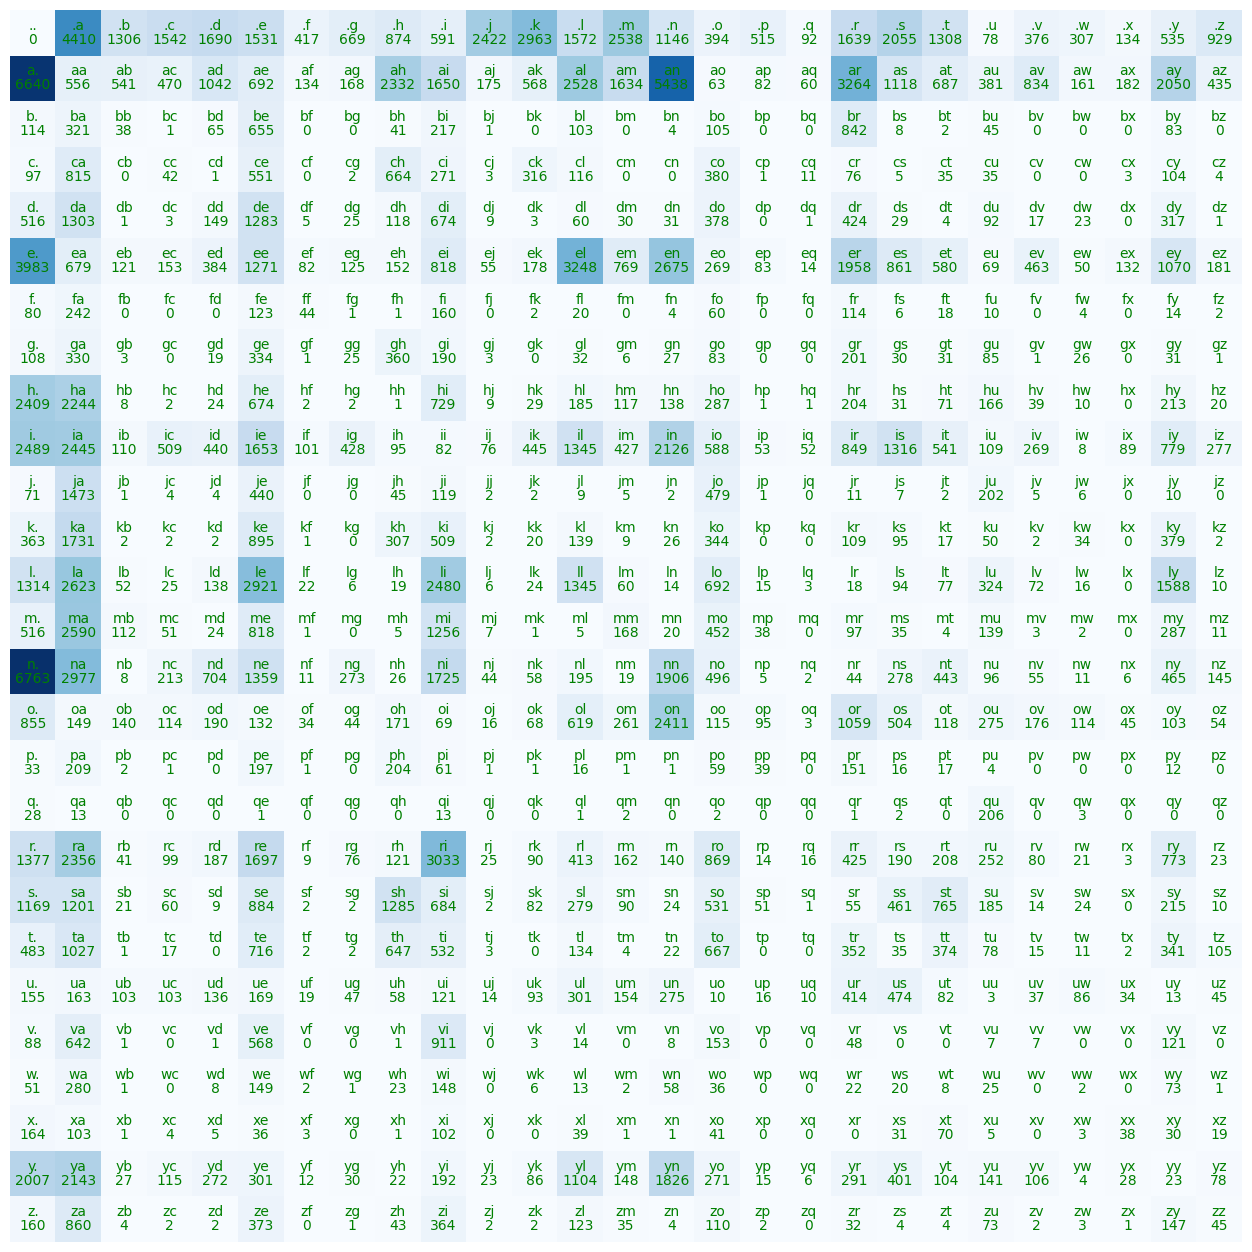

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize = (16, 16))
plt.imshow(bigrams, cmap='Blues')
for i in range(len(chars)):
    for j in range(len(chars)):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha = 'center', va = 'bottom', color = 'green')
        plt.text(j, i, bigrams[i,j].item(), ha = 'center', va = 'top', color = 'green')
plt.axis('off')

(-0.5, 26.5, 26.5, -0.5)

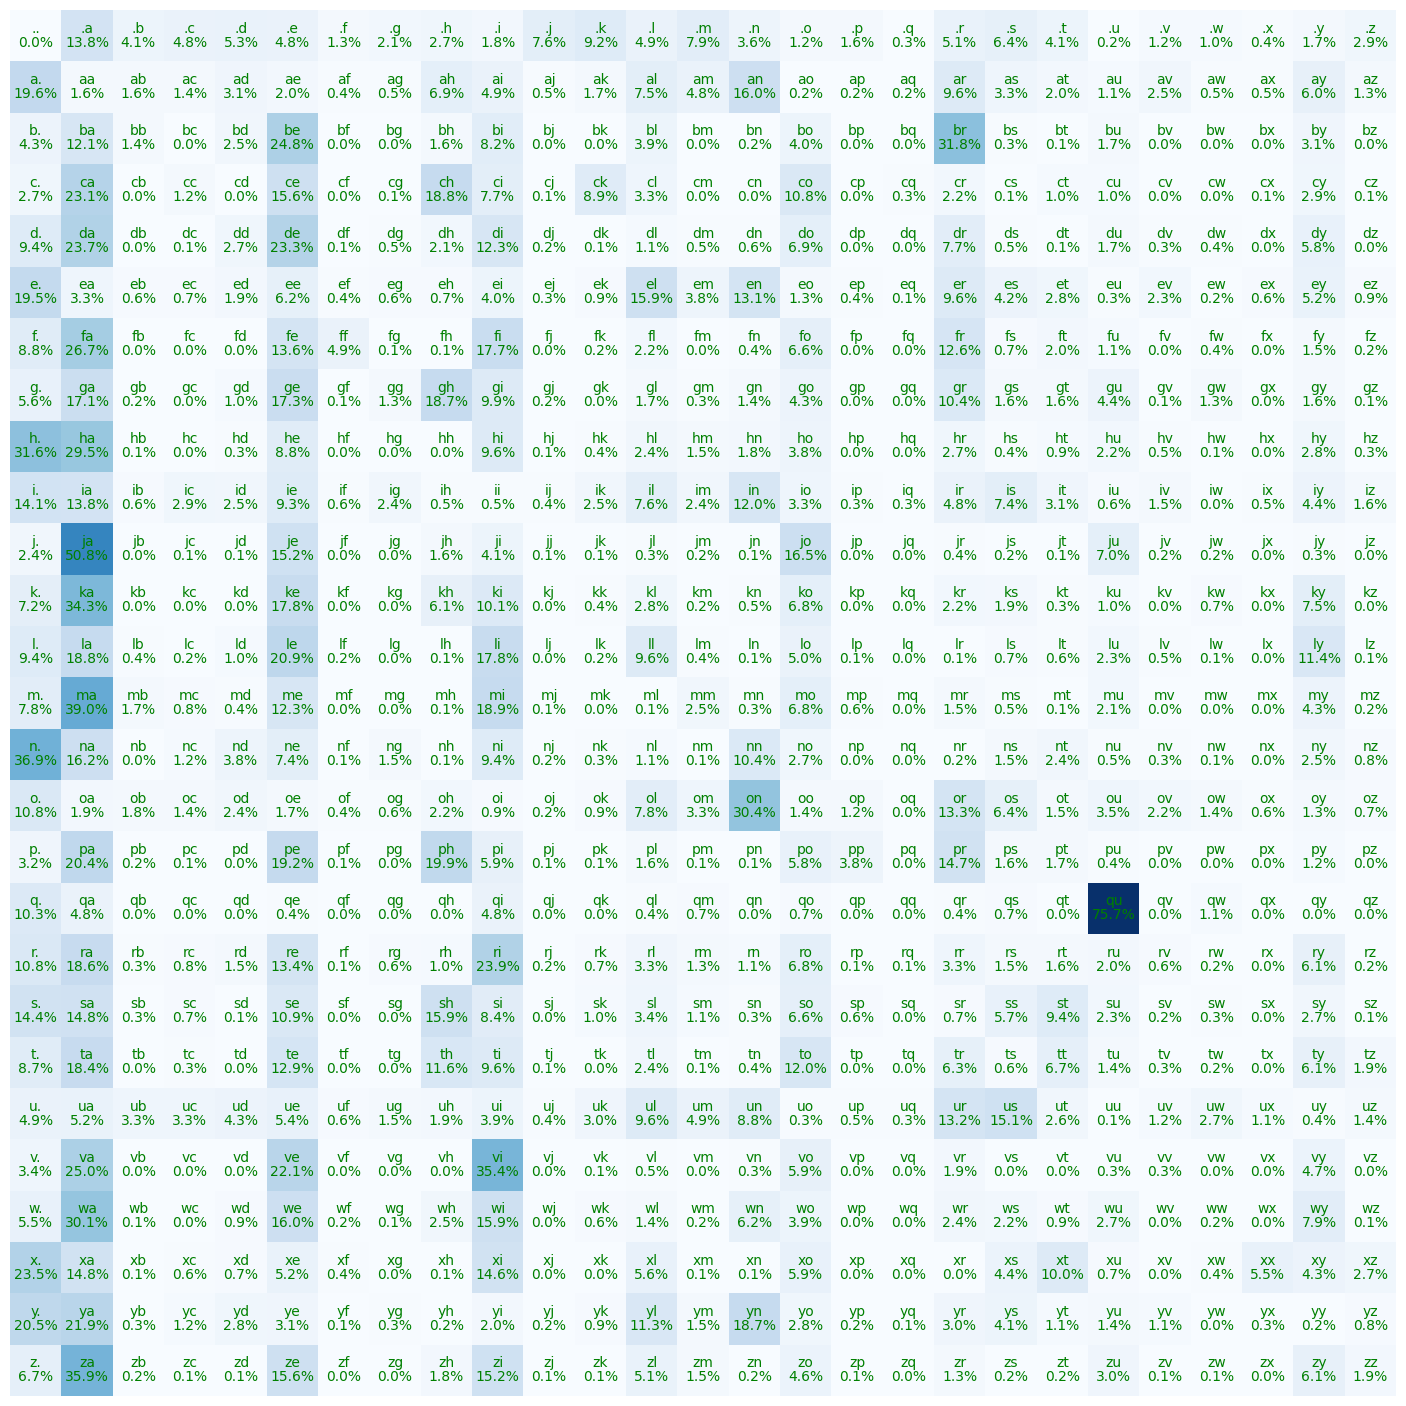

In [7]:
bigrams_prob = bigrams.float()
bigrams_prob /= bigrams_prob.sum(1, keepdim=True)

plt.figure(figsize = (18, 18))
plt.imshow(bigrams_prob, cmap='Blues')
for i in range(len(chars)):
    for j in range(len(chars)):
        chstr = itos[i] + itos[j]
        v = bigrams_prob[i,j].item() * 100.
        plt.text(j, i, chstr, ha = 'center', va = 'bottom', color = 'green')
        plt.text(j, i, f'{v:.1f}%', ha = 'center', va = 'top', color = 'green')
plt.axis('off')

In [8]:
generator = torch.Generator().manual_seed(2147483647)

def makename_bigram():
    output = ''
    current = '.'
    while True:
        probs = bigrams_prob[stoi[current]]
        next = itos[torch.multinomial(probs, 1, generator = generator, replacement=True).item()]

        if next == '.':
            break

        output += next
        current = next

    return output

# Returns "loss" instead of "goodness" of an argument.
# The bigger the value the worse the evaluation.
def evaluate_bigram(name):
    current = '.'
    log_likelihood = torch.tensor(0.0, device = 'cpu')

    for ch in (name + '.'):
        ix0 = stoi[current]
        ix1 = stoi[ch]

        prob = bigrams_prob[ix0, ix1]
        logprob = torch.log(prob)
        log_likelihood += logprob

        current = ch

    # We return negative log likelihood as a "loss" value,
    # normalized by length of the name. Another interpretation
    # is an average loss for each bigram in the name.
    return (-log_likelihood / len(name)).item()

In [9]:
for t in range(10):
    name = makename_bigram()
    eval = evaluate_bigram(name)
    print(f'{name}: {eval:.03}')

name = 'holz'
eval = evaluate_bigram(name)
print(f'{name}: {eval:.04}')
name = 'patrick'
eval = evaluate_bigram(name)
print(f'{name}: {eval:.03}')

junide: 2.8
janasah: 2.29
p: 7.57
cony: 2.93
a: 3.61
nn: 3.3
kohin: 2.87
tolian: 2.4
juee: 3.14
ksahnaauranilevias: 2.75
holz: 4.845
patrick: 3.2


In [10]:
#
# Prepare the training data
#
xs = '.' + '.'.join(names) + '.'

xenc = []
yenc = []

for ch0, ch1 in zip(xs, xs[1:]):
    xenc.append(stoi[ch0])
    yenc.append(stoi[ch1])

xenc = torch.tensor(xenc)
yenc = torch.tensor(yenc)

import torch.nn.functional
xenc = torch.nn.functional.one_hot(xenc, num_classes = len(chars)).float()
yenc = torch.nn.functional.one_hot(yenc, num_classes = len(chars)).float()

In [11]:
# Create neural net to predict next character, following the one got from input.
model = torch.randn(size = (len(chars), len(chars)), dtype = torch.float, requires_grad = True)

In [12]:
learning_rate = 1e-4

In [13]:
for t in range(200000):
    logits = xenc @ model
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdims = True)
    loss = (probs - yenc).pow(2).sum()

    if t % 100 == 99:
        print(t, loss.to('cpu').item())

    model.grad = None
    loss.backward()

    with torch.no_grad():
        model -= learning_rate * model.grad

99 209831.28125
199 205439.71875
299 203692.5625
399 202488.53125
499 201863.515625
599 201480.84375
699 201218.140625
799 200978.125
899 200677.84375
999 200439.046875
1099 200258.1875
1199 200089.640625
1299 199973.625
1399 199862.21875
1499 199753.265625
1599 199665.078125
1699 199606.59375
1799 199566.9375
1899 199535.21875
1999 199507.6875
2099 199483.421875
2199 199462.265625
2299 199443.84375
2399 199427.53125
2499 199412.65625
2599 199398.78125
2699 199385.78125
2799 199373.6875
2899 199362.640625
2999 199352.71875
3099 199343.734375
3199 199335.515625
3299 199327.875
3399 199320.6875
3499 199313.96875
3599 199307.609375
3699 199301.609375
3799 199295.875
3899 199290.375
3999 199284.984375
4099 199279.625
4199 199274.25
4299 199268.765625
4399 199263.125
4499 199257.25
4599 199251.125
4699 199244.6875
4799 199237.953125
4899 199230.96875
4999 199223.96875
5099 199217.125
5199 199210.8125
5299 199205.25
5399 199200.53125
5499 199196.484375
5599 199193.0
5699 199189.90625
5799 19

In [14]:
# Sample neural net for some names
sampling_generator = torch.Generator().manual_seed(2147483647)

def char2onehot(c):
    return torch.nn.functional.one_hot(torch.tensor(stoi[c], device = 'cpu'), num_classes = len(chars)).float()

def onehot2char(oh):
    return itos[torch.multinomial(oh.exp(), generator = sampling_generator, num_samples = 1).item()]

cpu_model = model.to('cpu')

for t in range(10):
    output = ''
    current = '.'
    while True:
        current_enc = char2onehot(current)
        pred = current_enc @ cpu_model
        next = onehot2char(pred)
    
        if next == '.':
            break
    
        output += next
        current = next

    eval = evaluate_bigram(output)
    print(f'{output}: {eval:.04}')

junide: 2.805
janasah: 2.294
p: 7.567
cony: 2.928
a: 3.613
nn: 3.295
kohin: 2.873
tolian: 2.401
juee: 3.145
ksahnaauranilevias: 2.753
